### Importando librerias necesarias

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,TimeSeriesSplit
import matplotlib.pyplot as plt
from Crossvalidation import MultipleTimeSeriesCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,RocCurveDisplay,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from Backtesting import backtest_1day_hold,backtest_1day_hold_train_test,backtest_1day_hold_train_test_market
from Crossvalidation import MultipleTimeSeriesCV,plot_time_series_split,walk_forward_validation
import warnings
warnings.filterwarnings("ignore")

### Cargamos los datos con las alfas

In [2]:
df = pd.read_csv('../spyconalfas.csv',index_col='Date')
df.drop('alpha53',axis=1,inplace=True)
df

,next movement,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-15,1,0.013966,143.668335,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
2013-10-16,1,0.006683,145.674850,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2013-10-17,1,0.006754,146.648438,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
2013-10-18,1,0.000057,147.638931,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
2013-10-21,1,0.005791,147.647400,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-07,0,-0.007635,362.790009,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,-0.986411,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2022-10-10,0,-0.006333,360.019989,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,-0.967626,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2022-10-11,0,-0.003298,357.739990,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,-0.566347,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544


<AxesSubplot:xlabel='Date'>

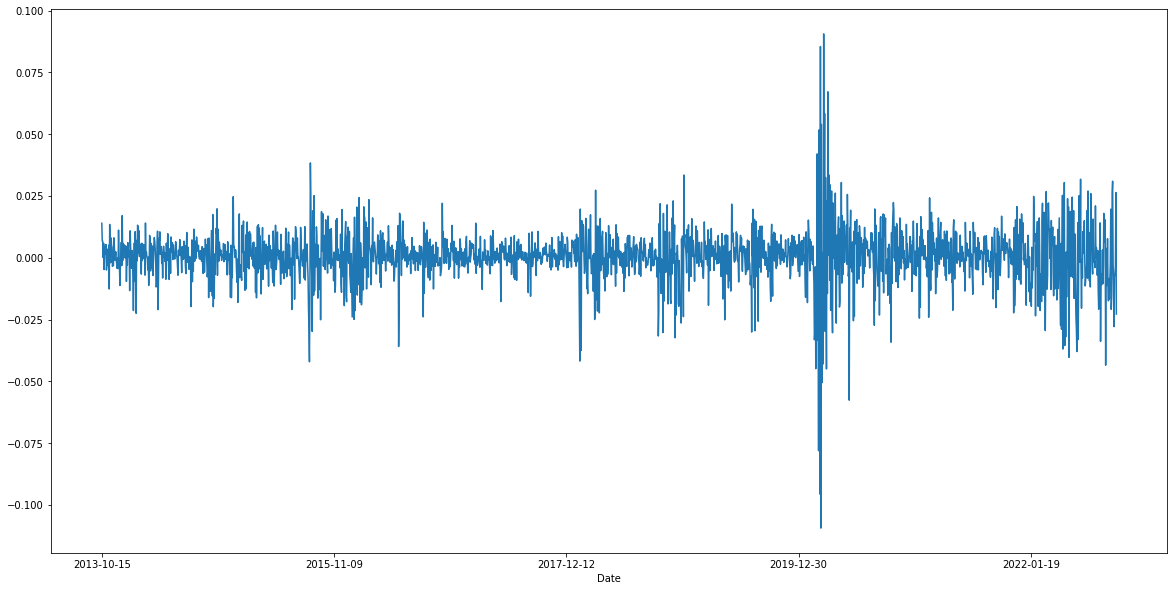

In [3]:
plt.figure(figsize=(20,10))
df['next returns'].plot()

In [4]:
Y = df['next movement']
df = df.drop('next movement',axis=1)

In [5]:
df

,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-15,0.013966,143.668335,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049835,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
2013-10-16,0.006683,145.674850,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006516,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2013-10-17,0.006754,146.648438,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973587,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
2013-10-18,0.000057,147.638931,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990494,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
2013-10-21,0.005791,147.647400,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008469,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-07,-0.007635,362.790009,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,-0.986411,10.410004,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2022-10-10,-0.006333,360.019989,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,-0.967626,2.770020,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2022-10-11,-0.003298,357.739990,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,-0.566347,-2.279999,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544


In [6]:
Y

Date
2013-10-15    1
2013-10-16    1
2013-10-17    1
2013-10-18    1
2013-10-21    1
             ..
2022-10-07    0
2022-10-10    0
2022-10-11    0
2022-10-12    1
2022-10-13    0
Name: next movement, Length: 2185, dtype: int64

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(df,Y,shuffle=False,test_size=0.2,stratify=None)

In [8]:
X_train

,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-15,0.013966,143.668335,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049835,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
2013-10-16,0.006683,145.674850,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006516,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2013-10-17,0.006754,146.648438,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973587,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
2013-10-18,0.000057,147.638931,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990494,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
2013-10-21,0.005791,147.647400,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008469,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30,0.005081,362.895050,-0.177497,0.434895,0.205681,-1.000000,-0.395891,-1.000000,-0.823741,-0.517090,...,-0.203209,-0.001908,0.003890,-0.001685,-0.003575,-0.003993,0.005592,-0.001173,0.002785,-0.006848
2020-12-31,-0.013614,364.738800,0.302447,0.134440,0.153597,-0.888889,-0.326286,-0.483333,-0.733014,-1.843750,...,-0.112299,0.001427,0.008591,0.000899,-0.001685,-0.003575,-0.003993,-0.004477,-0.004427,0.005994
2021-01-04,0.006887,359.773254,0.002006,0.553204,-0.080359,-0.222222,-0.465496,-0.150000,-0.156675,4.965546,...,-0.045660,0.005081,-0.001908,0.003890,0.000899,-0.001685,-0.003575,0.013519,0.010937,0.016114


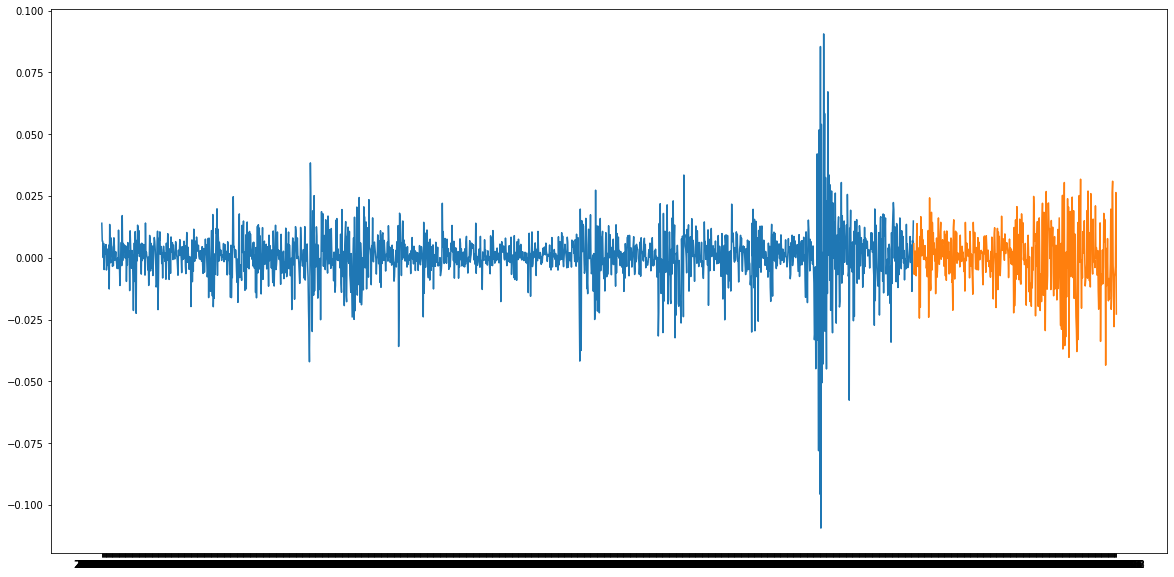

In [9]:
plt.subplots(figsize=(20,10))
plt.plot(X_train['next returns'])
plt.plot(X_test['next returns'])
plt.show()

In [10]:
X_train.drop('next returns',axis=1,inplace=True)
X_test.drop('next returns',axis=1,inplace=True)

Una vez que ya tenemos las separaciones train-test vamos a proceder a normalizar los datos, primero calculando las transformaciones dobre el conjunto de entrenamiento, y luego aplicando las mismas transformaciones sobre el conjunto de prueba.

In [11]:
X_train.describe()

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,...,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,226.318059,-0.000205,0.095224,0.228392,-0.653699,-0.248775,-0.554772,-0.496605,-0.138158,0.496278,...,-0.333725,0.000557,0.000582,0.000479,0.000472,0.000480,0.000518,0.000597,0.000581,0.000571
std,53.544227,0.276803,0.451406,0.384091,0.325972,0.135081,0.670345,0.274105,2.717071,0.274574,...,0.238254,0.010978,0.011021,0.011035,0.011045,0.011052,0.011056,0.011052,0.011028,0.011048
min,143.668335,-0.443642,-0.978837,-0.895961,-1.000000,-0.500199,-1.000000,-1.000000,-20.312088,0.000397,...,-0.994652,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424
25%,180.515022,-0.177497,-0.242479,-0.011643,-1.000000,-0.364030,-1.000000,-0.731115,-1.137115,0.262222,...,-0.503291,-0.003076,-0.003132,-0.003170,-0.003170,-0.003192,-0.003182,-0.003098,-0.003059,-0.003044
50%,220.392853,0.002006,0.115109,0.263202,-0.777778,-0.247407,-1.000000,-0.491607,-0.101288,0.495032,...,-0.290112,0.000597,0.000637,0.000552,0.000552,0.000588,0.000637,0.000637,0.000653,0.000643
75%,266.538589,0.302447,0.444271,0.539721,-0.333333,-0.134573,-0.166667,-0.262890,0.697960,0.729630,...,-0.132383,0.005182,0.005209,0.005142,0.005110,0.005161,0.005209,0.005325,0.005212,0.005227
max,364.738800,0.302447,0.972121,0.937606,-0.111111,-0.000199,1.000000,-0.002398,28.222427,1.000000,...,-0.000411,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603


En un principio la mayoria de las variables al ser ratios o porcentajes, tienen escalas similares. Sin embargo Close,Alfa53,Alfa54 y Alfa84 no estan en escalas cercanas al 0. Normalizamos:

In [12]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler=StandardScaler()
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [13]:
X_train

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-15,-1.544020,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049835,0.774245,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
2013-10-16,-1.506536,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006516,0.157393,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005787,0.007397
2013-10-17,-1.488348,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973587,0.275437,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004463,0.003139
2013-10-18,-1.469844,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990494,0.272655,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002657
2013-10-21,-1.469685,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008469,0.507552,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30,2.551462,-0.177497,0.434895,0.205681,-1.000000,-0.395891,-1.000000,-0.823741,-0.517090,0.370429,...,-0.203209,-0.001908,0.003890,-0.001685,-0.003575,-0.003993,0.005592,-0.001173,0.002785,-0.006848
2020-12-31,2.585906,0.302447,0.134440,0.153597,-0.888889,-0.326286,-0.483333,-0.733014,-1.843750,0.176868,...,-0.112299,0.001427,0.008591,0.000899,-0.001685,-0.003575,-0.003993,-0.004477,-0.004427,0.005994
2021-01-04,2.493142,0.002006,0.553204,-0.080359,-0.222222,-0.465496,-0.150000,-0.156675,4.965546,0.959459,...,-0.045660,0.005081,-0.001908,0.003890,0.000899,-0.001685,-0.003575,0.013519,0.010937,0.016114


In [14]:
X_test

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-07,2.681040,0.302447,0.773566,-0.260968,-1.000000,-0.444156,-0.616667,-0.880895,-5.414337,0.037361,...,-0.196627,0.005979,-0.013614,0.001427,-0.001908,0.008591,0.003890,-0.003993,0.008618,-0.004427
2021-01-08,2.720405,0.302447,0.478898,-0.160313,-1.000000,-0.479656,-0.750000,-0.888489,-2.107178,0.876789,...,-0.380090,0.014858,0.006887,0.005081,0.001427,-0.001908,0.008591,-0.003575,-0.002055,0.010937
2021-01-11,2.673568,0.002006,0.571287,0.123307,-1.000000,-0.428400,-1.000000,-0.930855,2.507141,0.894674,...,-0.283838,0.005698,0.005979,-0.013614,0.005081,0.001427,-0.001908,-0.001685,0.002926,0.002104
2021-01-12,2.675025,-0.177497,-0.827823,0.323170,-0.777778,-0.438172,-1.000000,-0.796163,-0.077972,0.483704,...,-0.444268,-0.006741,0.014858,0.006887,-0.013614,0.005081,0.001427,0.000899,-0.008969,-0.000272
2021-01-13,2.693615,-0.320899,-0.865147,0.430441,-1.000000,-0.405265,-1.000000,-0.714628,-0.995117,0.271463,...,-0.058121,0.000211,0.005698,0.005979,0.006887,-0.013614,0.005081,0.003890,-0.000327,0.008618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-07,2.549500,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,-0.986411,10.410004,0.990859,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2022-10-10,2.497752,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,-0.967626,2.770020,0.106518,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2022-10-11,2.455158,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,-0.566347,-2.279999,0.133943,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544


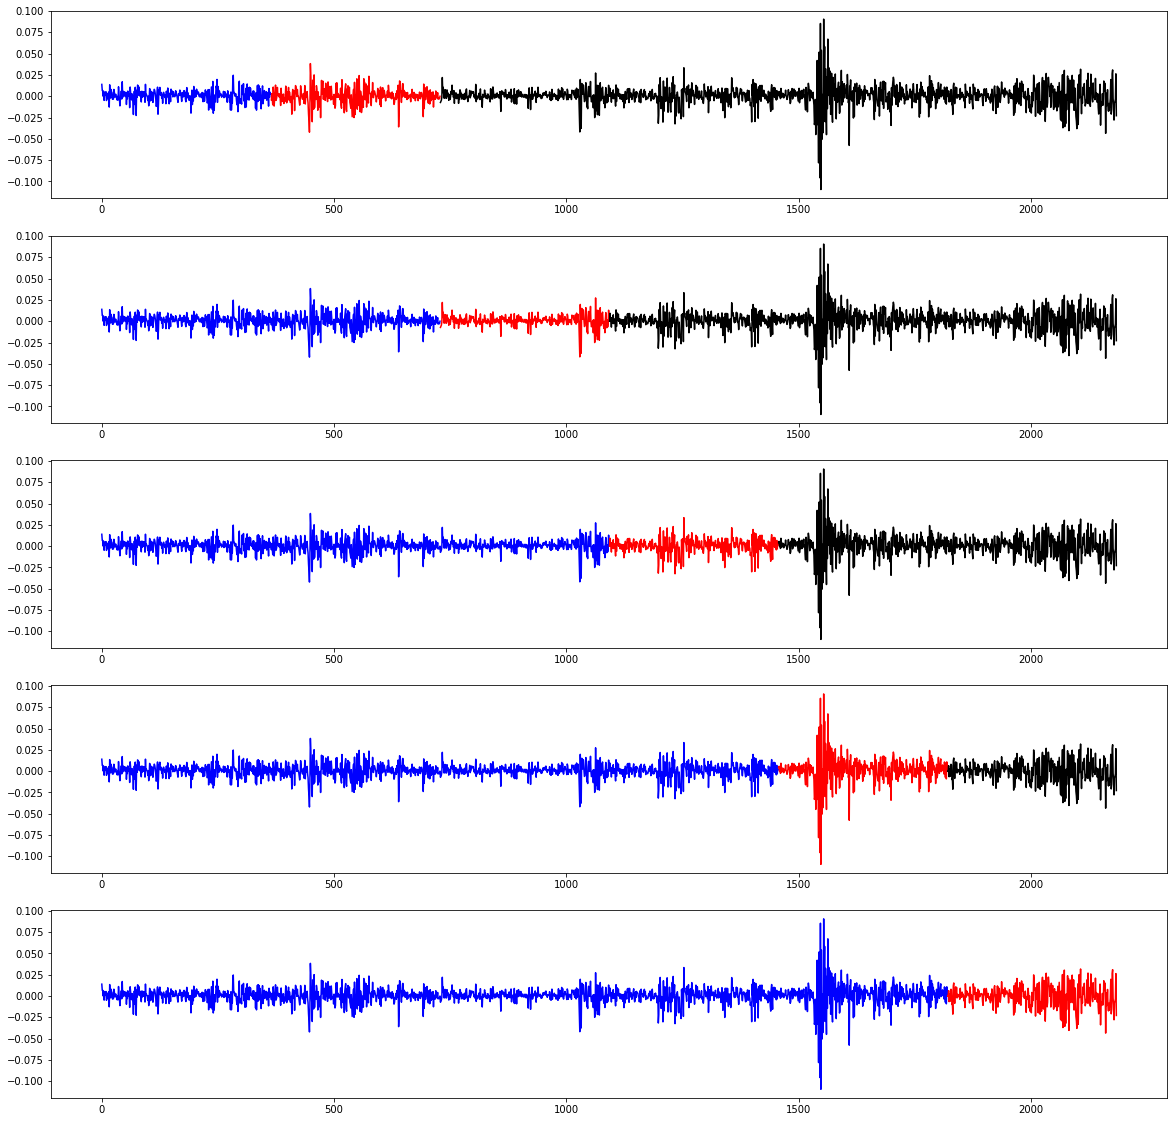

In [15]:
plot_time_series_split(df['next returns'],5)

In [16]:
X_train = X_train.to_numpy()
X_train

array([[-1.54402032e+00,  2.00561572e-03,  8.37104431e-01, ...,
        -4.59696912e-03,  2.24937500e-03,  9.57623586e-03],
       [-1.50653562e+00,  3.02446851e-01,  6.30210545e-01, ...,
        -5.32810820e-03,  5.78724600e-03,  7.39734251e-03],
       [-1.48834756e+00,  3.02446851e-01,  5.46596172e-01, ...,
         7.91616452e-03,  4.46271952e-03,  3.13858330e-03],
       ...,
       [ 2.49314244e+00,  2.00561572e-03,  5.53204260e-01, ...,
         1.35193054e-02,  1.09372945e-02,  1.61137415e-02],
       [ 2.53943284e+00, -1.77496992e-01,  6.63166574e-01, ...,
         1.56947080e-03,  2.10362551e-03, -1.54181332e-03],
       [ 2.57989212e+00, -3.20898516e-01,  8.09007872e-01, ...,
         5.59189859e-03, -2.72454429e-04,  2.78502428e-03]])

In [17]:
Y_train.describe()

count    1748.000000
mean        0.557780
std         0.496792
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: next movement, dtype: float64

In [18]:
Y_train = Y_train.to_numpy()
Y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

ENTRENAMIENTO DE MODELOS

Los modelos que vamos a entrenar son todos aquellos explicados en 3.1, en su versión para clasificación:
-Regresión Logistica
-SVM Clasificación
-Random Forest Clasificación
-XGBoost Clasificación
-ANN Clasificación

### Regresión Logística

In [19]:
cv = TimeSeriesSplit(5)
estimator = SGDClassifier()
param = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01,0.1,0.5,1],
    'max_iter' :[1000,10000],
    'alpha' : [0.001,0.01]
}
logreg = GridSearchCV(estimator,param_grid=param,cv=cv,verbose=0,scoring=['accuracy','roc_auc'],refit='roc_auc')
logreg.fit(X_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDClassifier(),
             param_grid={'alpha': [0.001, 0.01], 'eta0': [0.01, 0.1, 0.5, 1],
                         'loss': ['log'], 'max_iter': [1000, 10000],
                         'penalty': ['l1', 'l2']},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [20]:
logreg.best_params_

{'alpha': 0.001, 'eta0': 1, 'loss': 'log', 'max_iter': 10000, 'penalty': 'l1'}

              precision    recall  f1-score   support

           0       0.53      0.42      0.46       773
           1       0.60      0.70      0.65       975

    accuracy                           0.58      1748
   macro avg       0.56      0.56      0.56      1748
weighted avg       0.57      0.58      0.57      1748



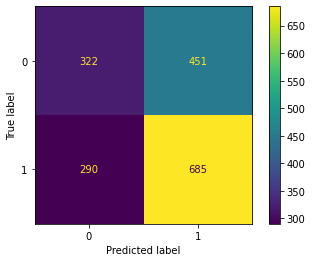

In [21]:
Y_pred = logreg.predict(X_train)
np.reshape(Y_pred,(len(Y_pred),1))
print(classification_report(Y_train, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)

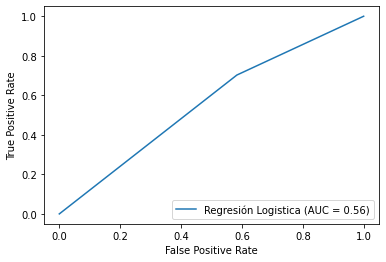

In [22]:
fpr, tpr, thresholds = roc_curve(Y_train, Y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Regresión Logistica')
display.plot()
plt.show()

### SVM - Clasificación

In [23]:
cv = TimeSeriesSplit(5)
estimator = SGDClassifier()
param = {
    'loss' : ['hinge'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01,0.1,0.5,1],
    'max_iter' :[1000,10000],
    'alpha' : [0.001,0.01]
}
svm = GridSearchCV(estimator,param_grid=param,cv=cv,verbose=0,scoring=['accuracy','roc_auc'],refit='accuracy')
svm.fit(X_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDClassifier(),
             param_grid={'alpha': [0.001, 0.01], 'eta0': [0.01, 0.1, 0.5, 1],
                         'loss': ['hinge'], 'max_iter': [1000, 10000],
                         'penalty': ['l1', 'l2']},
             refit='accuracy', scoring=['accuracy', 'roc_auc'])

In [24]:
svm.best_params_

{'alpha': 0.01, 'eta0': 1, 'loss': 'hinge', 'max_iter': 10000, 'penalty': 'l1'}

              precision    recall  f1-score   support

           0       0.51      0.17      0.26       773
           1       0.57      0.87      0.69       975

    accuracy                           0.56      1748
   macro avg       0.54      0.52      0.47      1748
weighted avg       0.55      0.56      0.50      1748



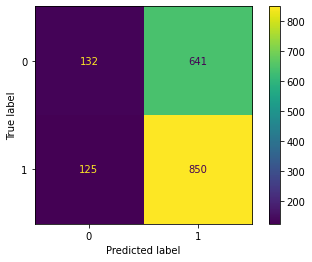

In [25]:
Y_pred = svm.predict(X_train)
np.reshape(Y_pred,(len(Y_pred),1))
print(classification_report(Y_train, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)

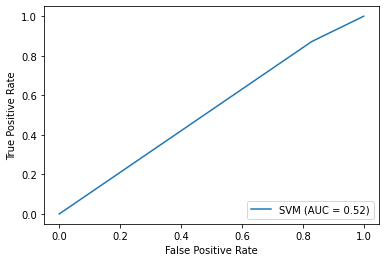

In [26]:
fpr, tpr, thresholds = roc_curve(Y_train, Y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='SVM')
display.plot()
plt.show()

### Random Forest - Clasificación

In [27]:
cv = TimeSeriesSplit(5)
estimator = RandomForestClassifier()
param = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
}
rf = GridSearchCV(estimator,param_grid=param,cv=cv,verbose=3,scoring=['accuracy','roc_auc'],refit='roc_auc')
rf.fit(X_train,Y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END criterion=gini, max_depth=3, n_estimators=100; accuracy: (test=0.509) roc_auc: (test=0.552) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=3, n_estimators=100; accuracy: (test=0.509) roc_auc: (test=0.544) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=3, n_estimators=100; accuracy: (test=0.550) roc_auc: (test=0.521) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=3, n_estimators=100; accuracy: (test=0.515) roc_auc: (test=0.466) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=3, n_estimators=100; accuracy: (test=0.557) roc_auc: (test=0.511) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=3, n_estimators=150; accuracy: (test=0.505) roc_auc: (test=0.520) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=3, n_estimators=150; accuracy: (test=0.522) roc_auc: (test=0.532) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=3, n_estimators=150; accuracy: 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 150, 200, 250, 300]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=3)

In [28]:
rf.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}

              precision    recall  f1-score   support

           0       1.00      0.30      0.46       773
           1       0.64      1.00      0.78       975

    accuracy                           0.69      1748
   macro avg       0.82      0.65      0.62      1748
weighted avg       0.80      0.69      0.64      1748



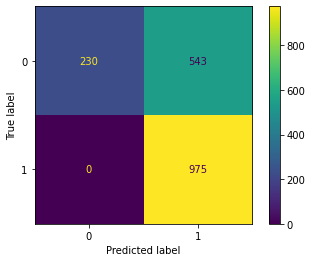

In [29]:
Y_pred = rf.predict(X_train)
np.reshape(Y_pred,(len(Y_pred),1))
print(classification_report(Y_train, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)

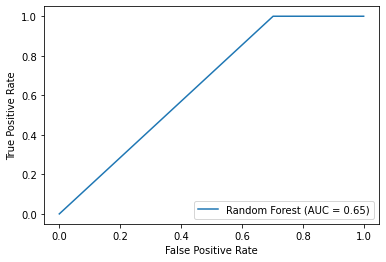

In [30]:
fpr, tpr, thresholds = roc_curve(Y_train, Y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Random Forest')
display.plot()
plt.show()

### XGBoost - Clasificación

In [31]:
cv = TimeSeriesSplit(5)
estimator = xgb.XGBClassifier()
param = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300],
    'gamma' : [0,1,5,10],
    'reg_alpha' : [0.001,0.01]
}
xgboost = RandomizedSearchCV(estimator,param_distributions=param,cv=cv,verbose=3,scoring=['accuracy','roc_auc'],refit='roc_auc')
xgboost.fit(X_train,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.01; accuracy: (test=0.546) roc_auc: (test=0.558) total time=   0.5s
[CV 2/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.01; accuracy: (test=0.481) roc_auc: (test=0.497) total time=   0.8s
[CV 3/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.01; accuracy: (test=0.509) roc_auc: (test=0.493) total time=   1.0s
[CV 4/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.01; accuracy: (test=0.498) roc_auc: (test=0.490) total time=   1.4s
[CV 5/5] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=300, reg_alpha=0.01; accuracy: (test=0.485) roc_auc: (test=0.523) total time=   1.6s
[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.001; accuracy: (test=0.543) roc_auc: (test=0.551) total time=   0.3s
[CV 2/5] END gamma=0, lea

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
             

In [32]:
xgboost.best_params_

{'reg_alpha': 0.001,
 'n_estimators': 150,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 5}

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       773
           1       0.90      0.99      0.94       975

    accuracy                           0.93      1748
   macro avg       0.94      0.92      0.93      1748
weighted avg       0.94      0.93      0.93      1748



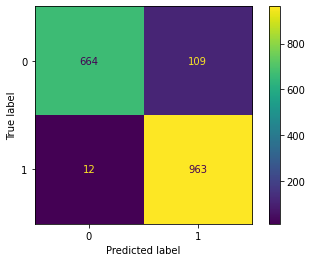

In [33]:
Y_pred = xgboost.predict(X_train)
np.reshape(Y_pred,(len(Y_pred),1))
print(classification_report(Y_train, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)

              precision    recall  f1-score   support

           0       0.48      0.28      0.35       213
           1       0.51      0.71      0.59       224

    accuracy                           0.50       437
   macro avg       0.49      0.49      0.47       437
weighted avg       0.49      0.50      0.48       437



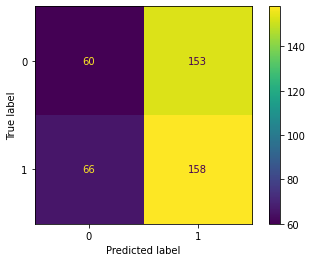

In [34]:
Y_pred = xgboost.predict(X_test)
np.reshape(Y_pred,(len(Y_pred),1))
print(classification_report(Y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)

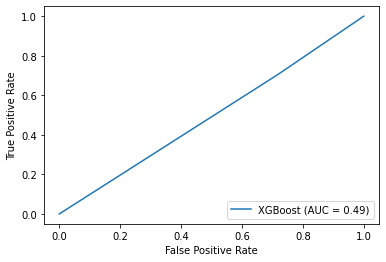

In [35]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='XGBoost')
display.plot()
plt.show()

### PROCESO COMPLETO

Vamos a llevar el proceso completo de entrenamiento y backtest de XGBoost para los parametros encontrados como mejores:

In [68]:
# Cargamos los datos originales
df = pd.read_csv('../spyconalfas.csv')

In [69]:
# Separamos en X - (conjunto de entrenamiento) y Y - (etiquetas de los movimientos)
Y = df['next movement']
X = df
X.drop(['next movement','alpha53'],axis=1,inplace=True)

Tras haber separado las etquetas de los datos y haber eliminado Date y Alpha53, procedemos a separar en Train/Test:

In [70]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)
print('Intervalo de entrenamiento:',X_train['Date'].iloc[0],'-',X_train['Date'].iloc[-1])
print('Intervalo de prueba:',X_test['Date'].iloc[0],'-',X_test['Date'].iloc[-1])

Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13


Ahora tomamos los retornos, los necesitaremos para calcular el rendimiento de nuestro algoritmo:

In [71]:
X_train_ret = X_train['next returns']
X_test_ret = X_test['next returns']
X_train.drop(['next returns','Date'],axis=1,inplace=True)
X_test.drop(['next returns','Date'],axis=1,inplace=True)

Añadimos el preprocesado necesario:

In [72]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler  = StandardScaler()

X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.01, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'shuffle': False}
Win rate: 0.5182648401826484
Mejores parametros:( accuracy ) SVM {'alpha': 0.001, 'eta0': 0.01, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
Win rate: 0.4908675799086758
Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 250, 'random_state': 42}
Win rate: 0.5068493150684932
Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.001, 'random_state': 42, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 10}
Win rate: 0.5365296803652968


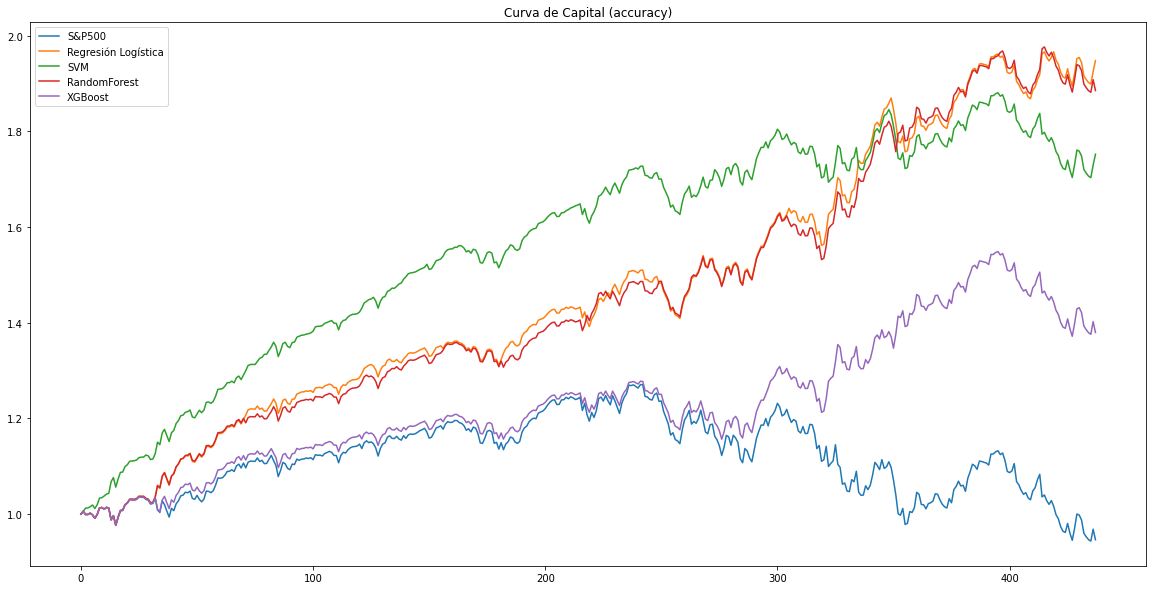

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
Win rate: 0.502283105022831
Mejores parametros:( roc_auc ) SVM {'alpha': 0.001, 'eta0': 0.01, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
Win rate: 0.4908675799086758
Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
Win rate: 0.4977168949771689
Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
Win rate: 0.5205479452054794


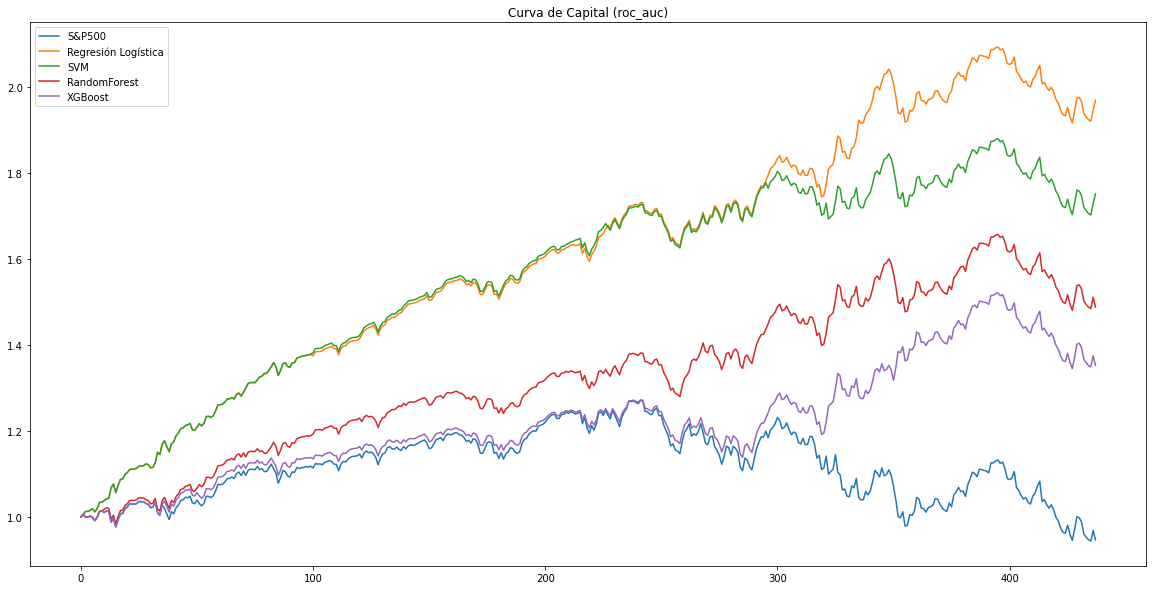

In [73]:
list_estimators = [SGDClassifier(),SGDClassifier(),RandomForestClassifier(),xgb.XGBClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost']
metricas = ['accuracy','roc_auc']
primero=True

param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01,0.1,0.5,1],
    'max_iter' :[1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

param_svm = {
    'loss' : ['hinge'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01,0.1,0.5,1],
    'max_iter' :[1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

param_rf = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}

param_xgb = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300],
    'gamma' : [0,1,5,10],
    'reg_alpha' : [0.001,0.01],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    plt.figure(figsize=(20,10))
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)
    for estimator,name in zip(list_estimators_entrenados,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()